# Benchmark Cases: EGM & DC-EGM

In [1]:
import io
import pickle
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

# from dcegm.consumption_retirement_model import (
#     compute_expected_value,
#     compute_next_period_marginal_utility,
#     inverse_marginal_utility_crra,
#     utility_func_crra,
# )
# from dcegm.solve import solve_dcegm
import jax
from functools import partial
import numba

In [30]:
size = 20000
a = np.arange(10)

In [35]:
def vector_sum(vector_entry):
    condition = vector_entry > 5
    return condition * (vector_entry + 2) + (1 - condition) * vector_entry + 3

In [28]:
size = 20000
big_matrix = np.ones((size, size))
vector = np.arange(size)

In [29]:
%timeit np.dot(big_matrix, vector)

259 ms ± 35.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
np.vectorize(vector_sum)(a)

array([ 3,  4,  5,  6,  7,  8, 11, 12, 13, 14])

In [37]:
jax.vmap(vector_sum)(a)

Array([ 3,  4,  5,  6,  7,  8, 11, 12, 13, 14], dtype=int32)

In [21]:
num_loop = 1_000

In [24]:
def loop_add_start_value(start, loop_num):
    for i in np.arange(1_000):
        indicator = int(i / 2) * 2 == i
        indicator_2 = start > 10_000
        case_1 = indicator * indicator_2
        case_2 = indicator * (1 - indicator_2)
        case_3 = (1 - indicator) * indicator_2
        case_4 = (1 - indicator) * (1 - indicator_2)
        start = (
            case_1 * (start + 1)
            + case_2 * (start + 0.5)
            + case_3 * (start + 2)
            + case_4 * (start + 1)
        )
    return start

In [25]:
jitted_if_loop = jax.jit(partial(loop_add_start_value, loop_num=num_loop))
%timeit jitted_if_loop(0)

21.2 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
@numba.jit(nopython=True, fastmath=True)
def loop_add_start_value_if(start, loop_num):
    for i in np.arange(loop_num):
        if int(i / 2) * 2 == i:
            if start > 10_000:
                start += 1
            else:
                start += 0.5
        else:
            if start > 10_000:
                start += 2
            else:
                start += 1
    return start

In [2]:
loop_add_start_value_if(0, num_loop)
%timeit loop_add_start_value_if(0, num_loop)

NameError: name 'loop_add_start_value_if' is not defined

In [ ]:
@numba.jit(nopython=True, fastmath=True)
def loop_add_start_value(start, loop_num):
    for i in np.arange(loop_num):
        indicator = int(i / 2) * 2 == i
        indicator_2 = start > 10_000
        case_1 = indicator * indicator_2
        case_2 = indicator * (1 - indicator_2)
        case_3 = (1 - indicator) * indicator_2
        case_4 = (1 - indicator) * (1 - indicator_2)
        start = (
            case_1 * (start + 1)
            + case_2 * (start + 0.5)
            + case_3 * (start + 2)
            + case_4 * (start + 1)
        )
    return start

In [ ]:
_ = loop_add_start_value(0, num_loop)
loop_add_start_value(0, num_loop)

In [26]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["figure.titlesize"] = "xx-large"
plt.rcParams["axes.labelsize"] = 14

In [3]:
def plot_optimal_consumption(
    policy: List[np.ndarray], params: pd.DataFrame, options: Dict[str, int]
) -> None:
    """Plots optimal consumption rules by age."""
    max_wealth = params.loc[("assets", "max_wealth"), "value"]
    n_periods = options["n_periods"]
    n_choices = options["n_discrete_choices"]

    if n_choices > 1:
        fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
        worker, retiree = 1, 0
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
        worker = 0

    fig.suptitle("Optimal Consumption Rules by Age")

    for period in range(n_periods - 1, -1, -1):
        ax.plot(policy[period][worker][0, :], policy[period][worker][1, :], linewidth=1)
        ax.set_xlim(0, max_wealth)
        ax.set_ylim(0, max_wealth)

        ax.set_xlabel("assets_end_of_period")
        ax.set_ylabel("Optimal Consumption")
        ax.set_title("Worker", fontweight="bold")

    if n_choices > 1:
        for period in range(n_periods - 1, -1, -1):
            ax2.plot(
                policy[period][retiree][0, :],
                policy[period][retiree][1, :],
                linewidth=1,
            )
            ax2.set_xlim(0, max_wealth)
            ax2.set_ylim(0, max_wealth)

            ax2.set_xlabel("assets_end_of_period")
            ax2.set_title("Retiree", fontweight="bold")

    plt.tight_layout()


def plot_value_function(
    value: List[np.ndarray], params: pd.DataFrame, options: Dict[str, int]
) -> None:
    """Plots optimal consumption rules by age."""
    max_wealth = params.loc[("assets", "max_wealth"), "value"]
    n_periods = options["n_periods"]
    n_choices = options["n_discrete_choices"]

    if n_choices > 1:
        fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
        worker, retiree = 1, 0
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
        worker = 0

    fig.suptitle("Value Functions by Age")

    for period in range(n_periods - 2, -1, -1):
        ax.plot(value[period][worker][0, :], value[period][worker][1, :], linewidth=1)
        ax.set_xlim(0, max_wealth)
        ax.set_ylim(-15, 15)

        ax.set_xlabel("assets_end_of_period")
        ax.set_ylabel("Value function")
        ax.set_title("Worker", fontweight="bold")

    if n_choices > 1:
        for period in range(n_periods - 2, -1, -1):
            ax2.plot(
                value[period][retiree][0, :], value[period][retiree][1, :], linewidth=1
            )
            ax2.set_xlim(0, max_wealth)
            ax2.set_ylim(-15, 15)

            ax2.set_xlabel("assets_end_of_period")
            ax2.set_title("Retiree", fontweight="bold")

    plt.tight_layout()

## Specify *utility functions*, *params* and *options*

In [4]:
utility_functions = {
    "utility": utility_func_crra,
    "inverse_marginal_utility": inverse_marginal_utility_crra,
    "next_period_marginal_utility": compute_next_period_marginal_utility,
}

In [5]:
params = """category,name,value,comment
discount_factor,discount_factor,0.95,discount factor
delta,delta,0,disutility of work
utility_function,theta,1,CRRA coefficient
wage,constant,0.75,age-independent labor income
wage,exp,0.04,return to experience
wage,exp_squared,-0.0004,return to experience squared
shocks,income_shock_std,0.25,shock on labor income income_shock_std parameter/standard deviation
shocks,lambda,0.00,taste shock (scale) parameter
assets,interest_rate,0.05,interest rate on capital
assets,initial_wealth_low,0,lowest level of initial wealth (relevant for simulation)
assets,initial_wealth_high,30,highest level of initial wealth (relevant for simulation)
assets,max_wealth,75,maximum level of wealth
assets,consumption_floor,0.0,consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
"""

In [6]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value  \
category         name                           
beta             beta                  0.9500   
delta            delta                 0.0000   
utility_function theta                 1.0000   
wage             constant              0.7500   
                 exp                   0.0400   
                 exp_squared          -0.0004   
shocks           sigma                 0.2500   
                 lambda                0.0000   
assets           interest_rate         0.0500   
                 initial_wealth_low    0.0000   
                 initial_wealth_high  30.0000   
                 max_wealth           75.0000   
                 consumption_floor     0.0000   

                                                                                comment  
category         name                                                                    
beta             beta                                                   discount factor  
delta            delta                                               disutility of work  
utility_function theta                                                 CRRA coefficient  
wage             constant                                  age-independent labor income  
                 exp                                               return to experience  
                 exp_squared                               return to experience squared  
shocks           sigma                shock on labor income sigma parameter/standard...  
                 lambda                                   taste shock (scale) parameter  
assets           interest_rate                                 interest rate on capital  
                 initial_wealth_low   lowest level of initial wealth (relevant for s...  
                 initial_wealth_high  highest level of initial wealth (relevant for ...  
                 max_wealth                                     maximum level of wealth  
                 consumption_floor    consumption floor/retirement safety net (only ...

In [7]:
options = """n_periods: 25
min_age: 20
n_discrete_choices: 1
grid_points_wealth: 100
quadrature_points_stochastic: 10
"""

In [8]:
options = yaml.safe_load(options)
options

{'n_periods': 25,
 'min_age': 20,
 'n_discrete_choices': 1,
 'grid_points_wealth': 100,
 'quadrature_points_stochastic': 10,
 'n_simulations': 10}

# 1) EGM: Consumption Savings Model with Income Shocks and Credit Constraint alla Deaton

In [9]:
policy_deaton, value_deaton = solve_dcegm(
    params,
    options,
    utility_functions,
    compute_expected_value,
)

In [10]:
# Compare with expected results from MATLAB
TEST_RESOURCES_DIR = "../../../tests/resources/"

policy_expected = pickle.load(open(TEST_RESOURCES_DIR + "policy_deaton.pkl", "rb"))
value_expected = pickle.load(open(TEST_RESOURCES_DIR + "value_deaton.pkl", "rb"))


for period in range(23, -1, -1):
    for choice in [0]:
        np.testing.assert_array_almost_equal(
            policy_deaton[period, choice, :][
                :,
                ~np.isnan(policy_deaton[period, choice, :]).any(axis=0),
            ],
            policy_expected[period, choice],
        )
        np.testing.assert_array_almost_equal(
            value_deaton[period, choice, :][
                :,
                ~np.isnan(value_deaton[period, choice, :]).any(axis=0),
            ],
            value_expected[period, choice],
        )

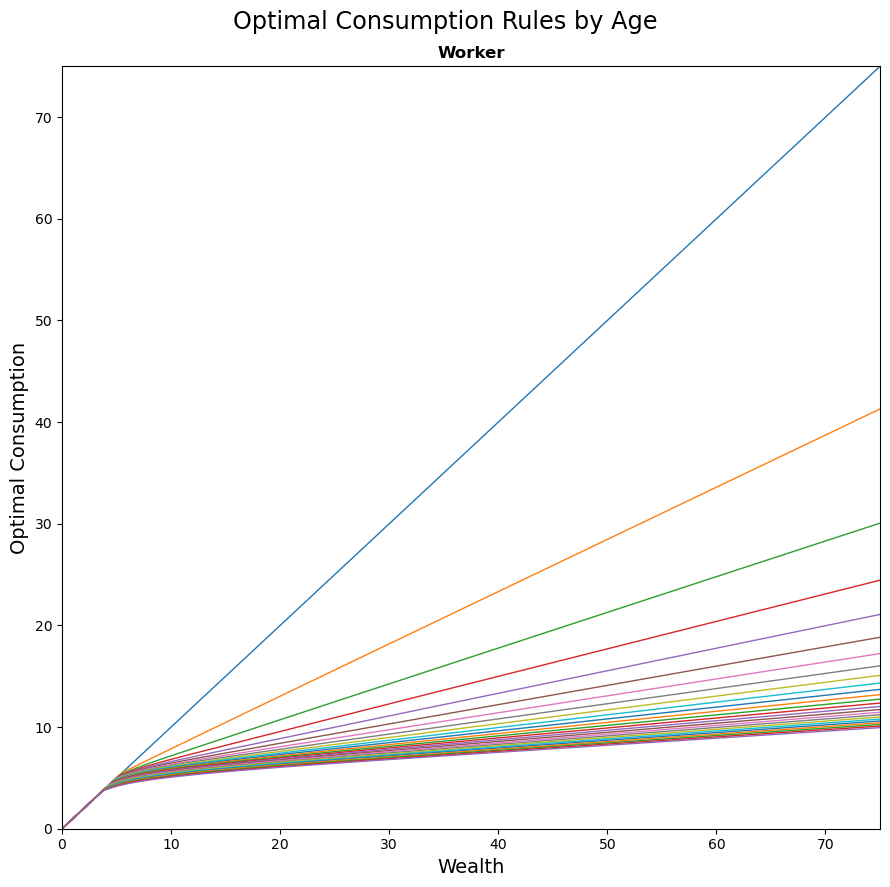

In [11]:
plot_optimal_consumption(policy_deaton, params, options)

In [12]:
# The older the agent, the steeper (more positive) the curve (i.e. the more is consumed
# and the less is saved).

# Final period, everything consumed, nothing saved

# 2) DC-EGM: Retirement Model

## a) Without taste shocks

### Update *params* and *options*

In [13]:
params.loc[("discount_factor", "discount_factor"), "value"] = 0.95
params.loc[("delta", "delta"), "value"] = 0.35
params.loc[("utility_function", "theta"), "value"] = 1.95
params.loc[("wage", "exp_squared"), "value"] = -0.0002
params.loc[("shocks", "income_shock_std"), "value"] = 0.00
params.loc[("shocks", "taste_shock_scale"), "value"] = 2.2204e-16
params.loc[("assets", "max_wealth"), "value"] = 50
params.loc[("assets", "consumption_floor"), "value"] = 0.001

params.loc[("discount_factor", "discount_factor"), "value"] = 0.95
params.loc[("shocks", "income_shock_std"), "value"] = 0.00
params.loc[("shocks", "taste_shock_scale"), "value"] = 2.2204e-16

In [14]:
options["n_discrete_choices"] = 2
options["grid_points_wealth"] = 500
options["quadrature_points_stochastic"] = 5

In [15]:
policy_retirement, value_retirement = solve_dcegm(
    params,
    options,
    utility_functions,
    compute_expected_value,
)

In [16]:
with open(TEST_RESOURCES_DIR + "policy_retirement_no_taste_shocks.pkl", "rb") as file:
    policy_expected = pickle.load(file)
with open(TEST_RESOURCES_DIR + "value_retirement_no_taste_shocks.pkl", "rb") as file:
    value_expected = pickle.load(file)

for period in range(23, -1, -1):
    for choice in [1, 0]:
        np.testing.assert_array_almost_equal(
            policy_retirement[period, choice, :][
                :,
                ~np.isnan(policy_retirement[period, choice, :]).any(axis=0),
            ],
            policy_expected[period][choice].T,
        )
        np.testing.assert_array_almost_equal(
            value_retirement[period, choice, :][
                :,
                ~np.isnan(value_retirement[period, choice, :]).any(axis=0),
            ],
            value_expected[period][choice].T,
        )

Note the kinks in the value function of the worker and discontinuities in the optimal consumption rules.

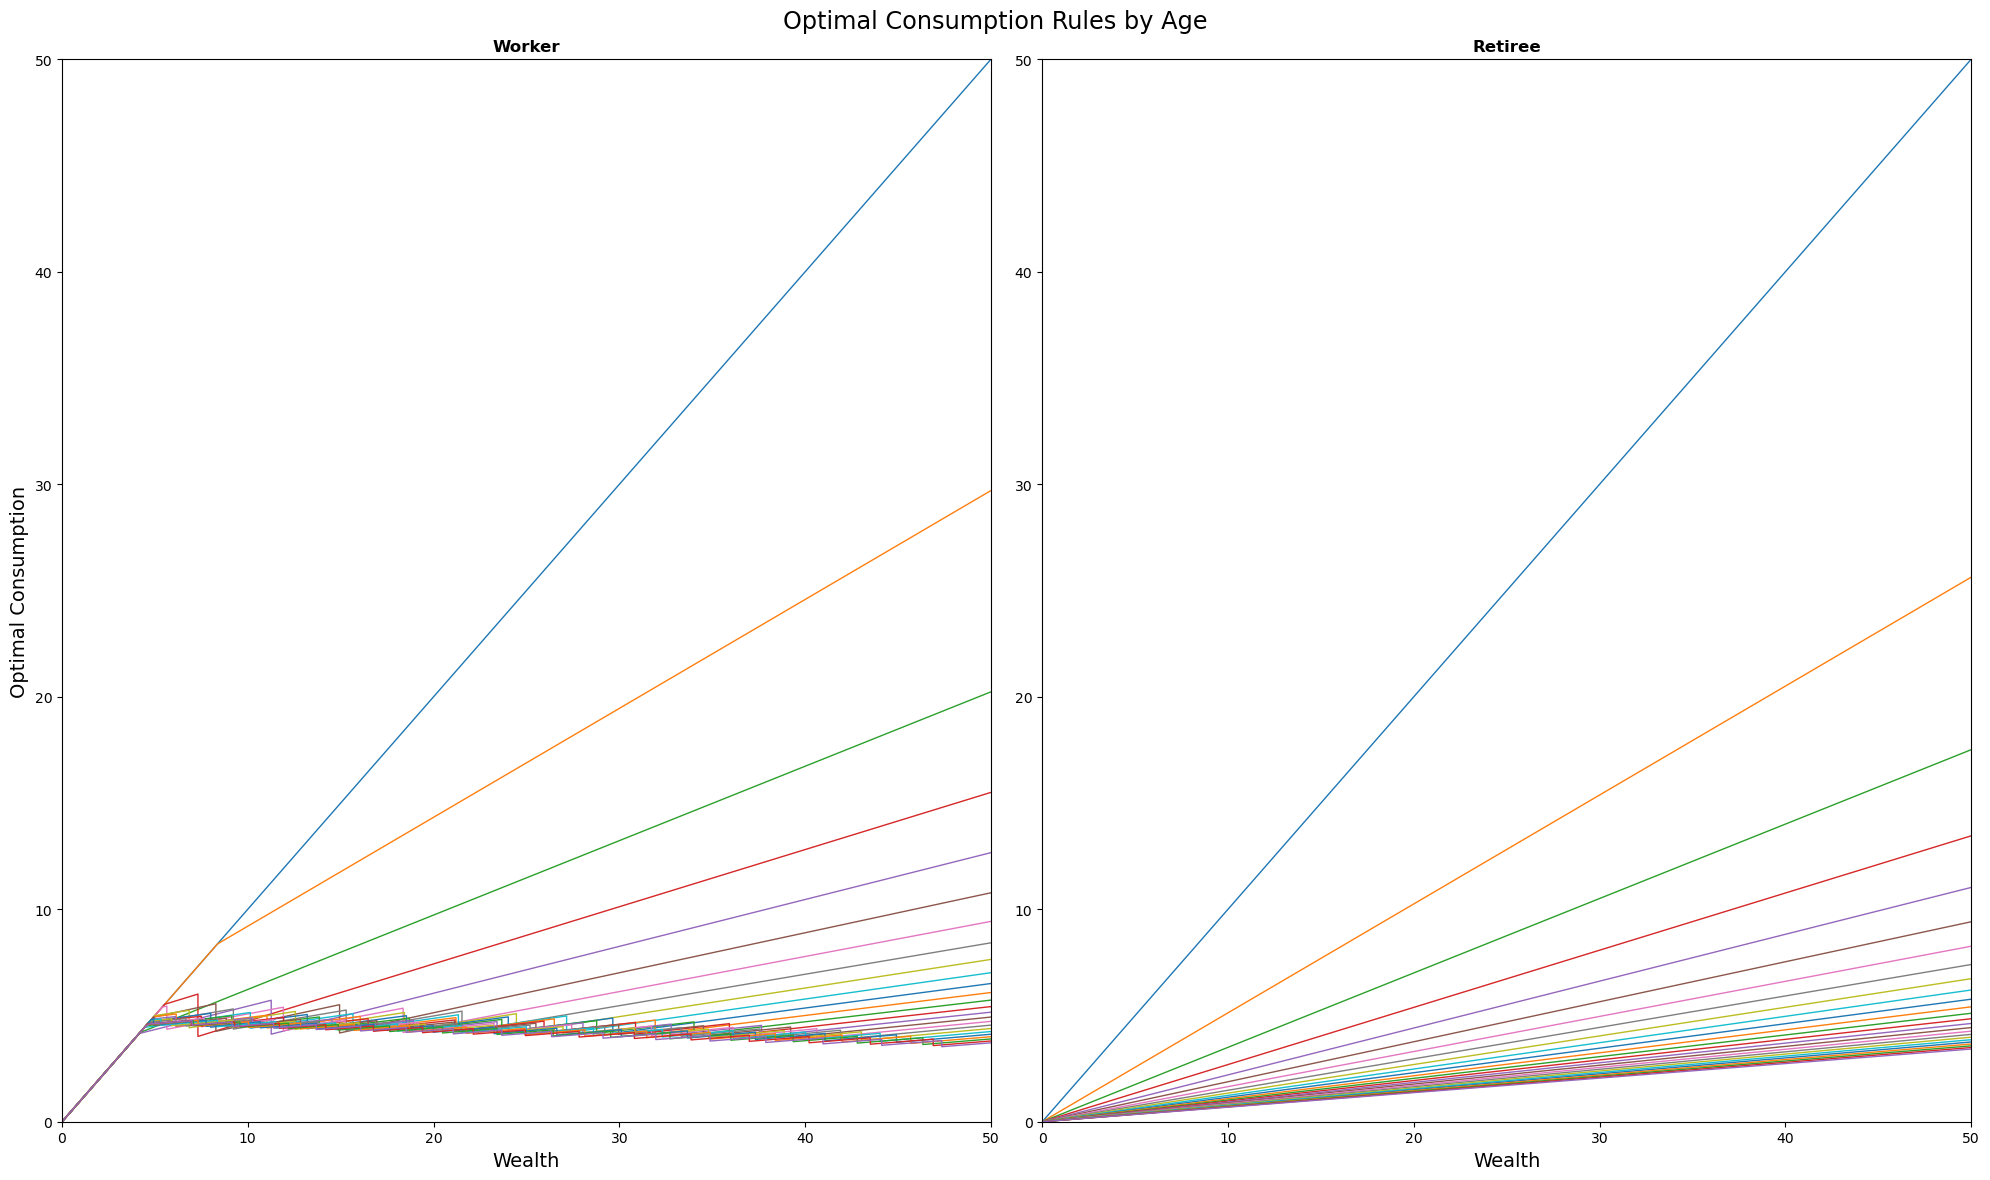

In [17]:
plot_optimal_consumption(policy_retirement, params, options)

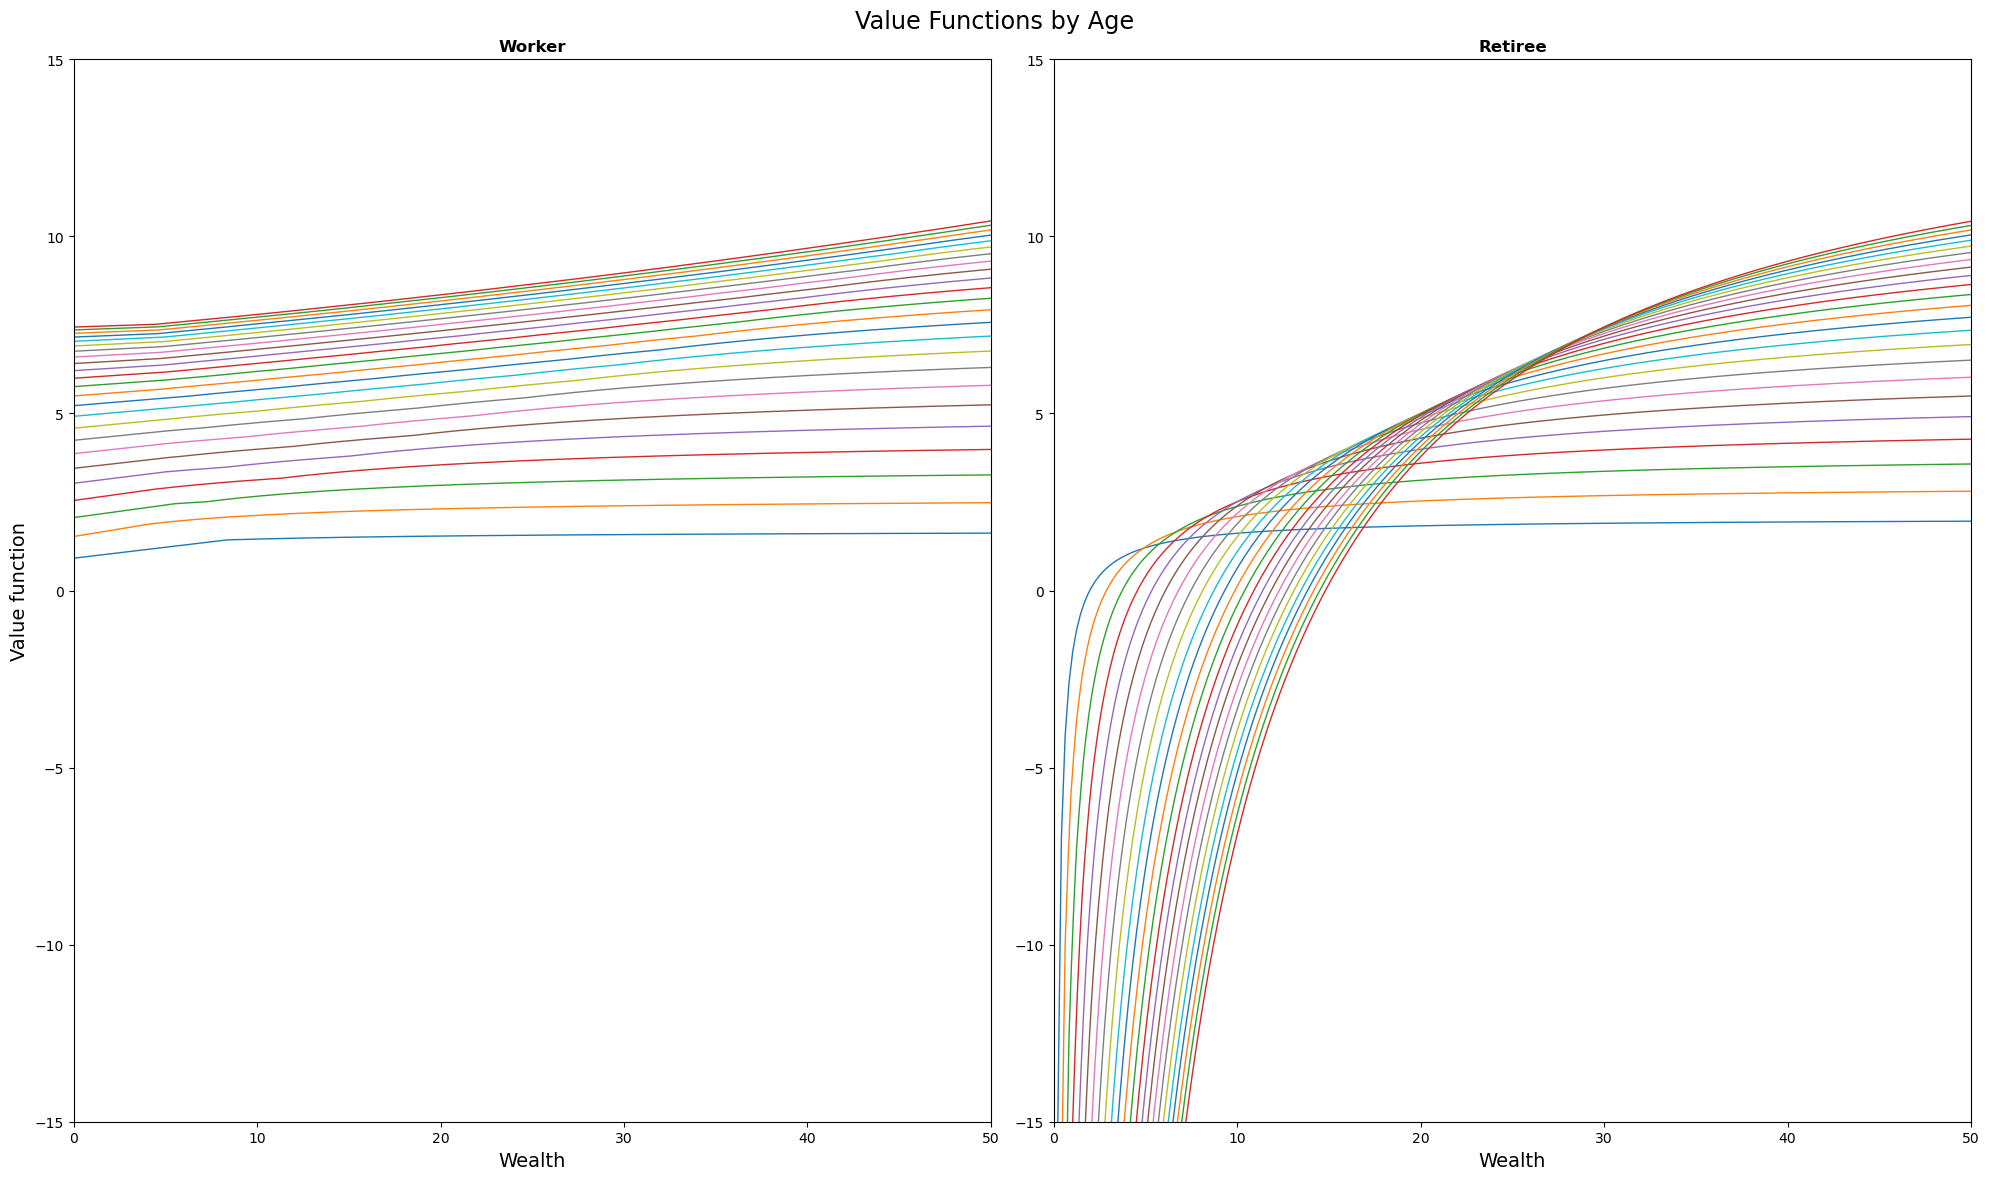

In [18]:
plot_value_function(value_retirement, params, options)

## b) With taste shocks

### Update *params*

In [19]:
r = params.loc[("assets", "interest_rate"), "value"]
params.loc[("discount_factor", "discount_factor"), "value"] = 1 / (1 + r)
params.loc[("shocks", "income_shock_std"), "value"] = 0.35
params.loc[("shocks", "taste_shock_scale"), "value"] = 0.2

In [20]:
policy_retirement, value_retirement = solve_dcegm(
    params,
    options,
    utility_functions,
    compute_expected_value,
)

In [21]:
with open(TEST_RESOURCES_DIR + "policy_retirement_taste_shocks.pkl", "rb") as file:
    policy_expected = pickle.load(file)
with open(TEST_RESOURCES_DIR + "value_retirement_taste_shocks.pkl", "rb") as file:
    value_expected = pickle.load(file)

for period in range(23, -1, -1):
    for choice in [1, 0]:
        np.testing.assert_array_almost_equal(
            policy_retirement[period, choice, :][
                :,
                ~np.isnan(policy_retirement[period, choice, :]).any(axis=0),
            ],
            policy_expected[period][choice].T,
        )
        np.testing.assert_array_almost_equal(
            value_retirement[period, choice, :][
                :,
                ~np.isnan(value_retirement[period, choice, :]).any(axis=0),
            ],
            value_expected[period][choice].T,
        )

The kinks in the value function of the worker and discontinuities in the optimal consumption rules are smoothed with extreme value distributed taste shocks

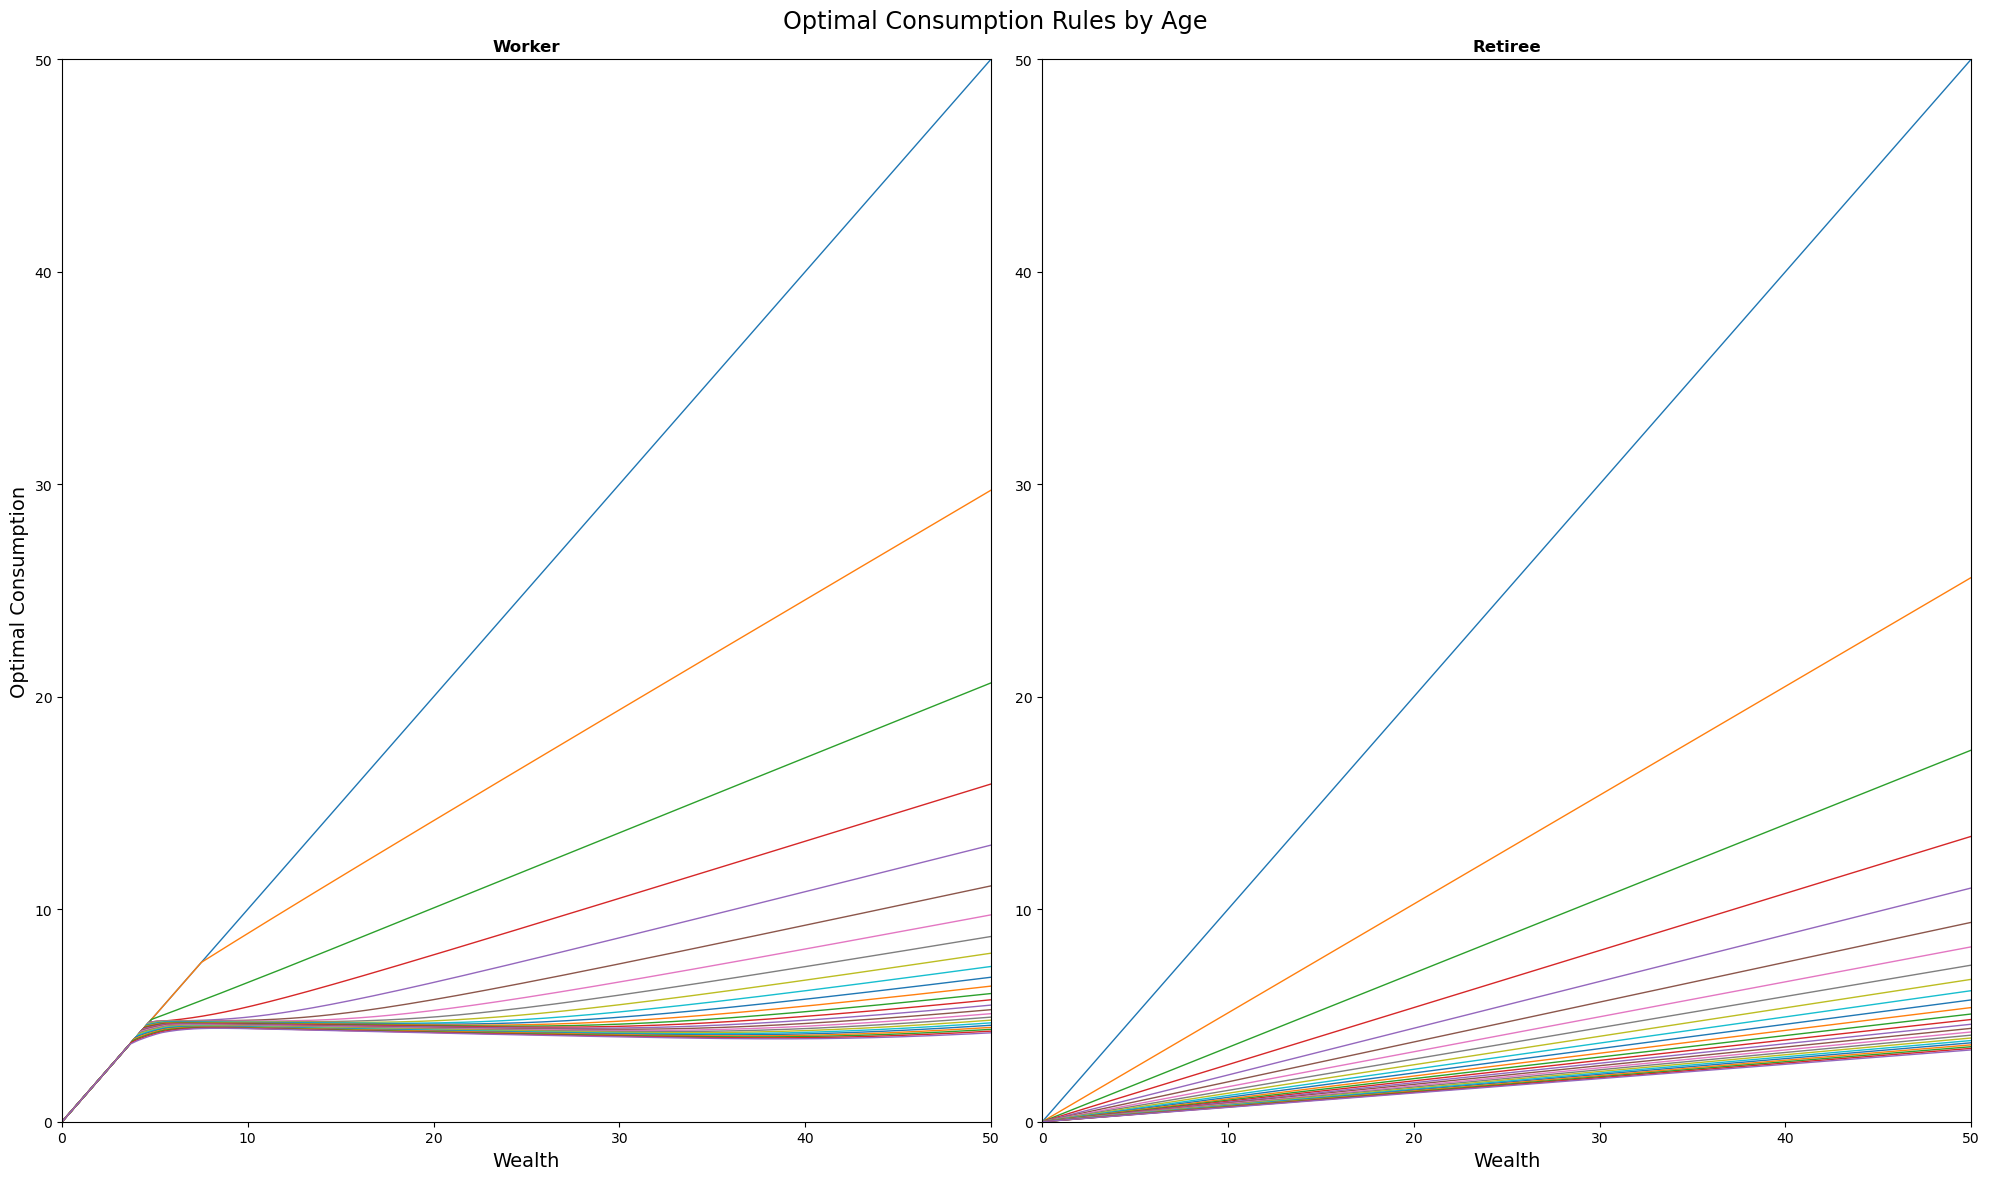

In [22]:
plot_optimal_consumption(policy_retirement, params, options)

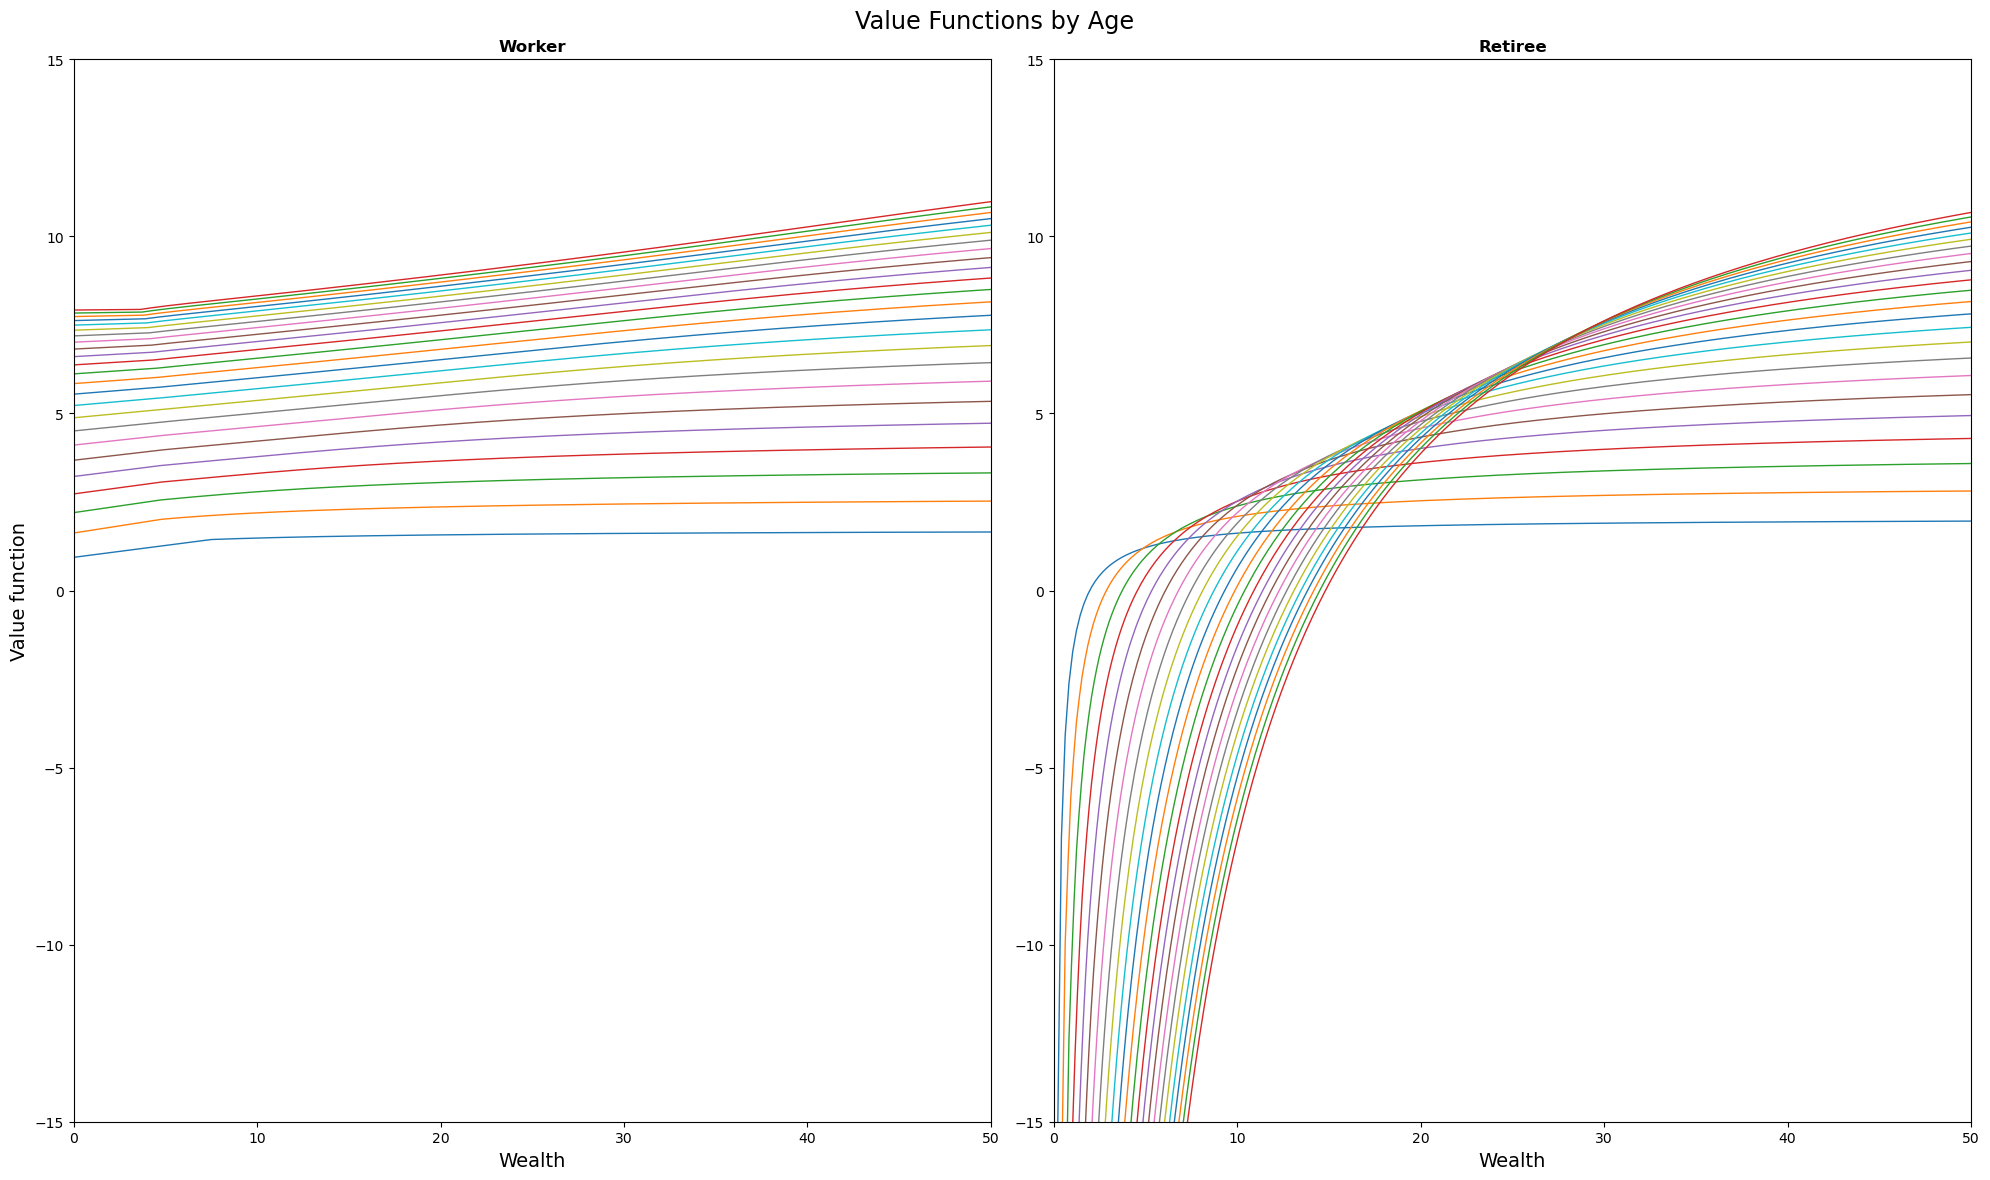

In [23]:
plot_value_function(value_retirement, params, options)